# Combined labels for both cells and nuclei for bone_s0
# Version with late fusion PCA

In [1]:
slide_id = "bone_s0"

In [2]:
import pandas as pd
import scanpy as sc
import spatialdata as sd
import numpy as np
import anndata as ad
from spatialdata.models import get_table_keys
from matplotlib.colors import to_rgba
from functools import partial
from matplotlib import colors
import gc

## 1. Load the data

In [3]:
sdata_final = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables',))

cellid2transcript_cat = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'transcript_cat']].values)

cellid2nucleilabel = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'final_label']].values)
cellid2celllabel = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'final_label']].values)

cellid2nucleilabel1 = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'label1']].values)
cellid2celllabel1 = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'label1']].values)

del sdata_final
gc.collect()

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


1128

In [4]:
sdata_processed = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_{slide_id}.zarr", selection=('tables',))
sdata_processed

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_bone_s0.zarr
└── Tables
      ├── 'table_cells': AnnData (33801, 477)
      └── 'table_nuclei': AnnData (33801, 541)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ nucleus_boundaries (Shapes)
    ▸ cell_boundaries (Shapes)
    ▸ he (Images)
    ▸ morpho (Images)
    ▸ st (Points)

In [5]:
adata_nuclei_ini = sdata_processed.tables['table_nuclei'].copy()
adata_nuclei_ini

AnnData object with n_obs × n_vars = 33801 × 541
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial', 'tangram_pred'

In [6]:
adata_nuclei_ini.var

Empty DataFrame
Columns: []
Index: [ABCC11, ACAN, ACE2, ACKR1, ACTA2, ACTG2, ADAM28, ADAMTS1, ADD2, ADGRE1, ADGRL4, ADH1C, ADH4, ADIPOQ, AGER, AGR3, AHSP, AIF1, ALAS2, ALDH1A3, ALPL, AMY2A, ANGPT2, ANPEP, APCDD1, APOA5, APOBEC3A, APOLD1, AQP2, AQP3, AQP8, AQP9, AR, ARFGEF3, ARG1, ART4, ASCL1, ASCL3, ASPN, AXIN2, BAMBI, BANK1, BASP1, BBOX1, BCL2L11, BLK, BMP2, BMP4, BMX, BTNL9, C15orf48, C1orf162, C1orf194, C20orf85, C5orf46, C6orf118, C7, CA4, CADM1, CALD1, CAPN8, CAV1, CAVIN1, CAVIN2, CCDC39, CCDC78, CCL19, CCL27, CCL5, CCNB2, CCR2, CCR7, CD14, CD163, CD19, CD1A, CD1C, CD1E, CD2, CD24, CD247, CD27, CD274, CD28, CD300E, CD34, CD3D, CD3E, CD4, CD40, CD40LG, CD5L, CD68, CD69, CD70, CD79A, CD83, CD86, CD8A, CD93, ...]

[541 rows x 0 columns]

In [7]:
adata_cells_ini = sdata_processed.tables['table_cells'].copy()
adata_cells_ini

AnnData object with n_obs × n_vars = 33801 × 477
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [8]:
adata_cells_ini.var

gene_ids    feature_types   genome
ABCC11  ENSG00000121270  Gene Expression  Unknown
ACAN    ENSG00000157766  Gene Expression  Unknown
ACE2    ENSG00000130234  Gene Expression  Unknown
ACKR1   ENSG00000213088  Gene Expression  Unknown
ACTA2   ENSG00000107796  Gene Expression  Unknown
...                 ...              ...      ...
VPREB3  ENSG00000128218  Gene Expression  Unknown
VSIG4   ENSG00000155659  Gene Expression  Unknown
VWA5A   ENSG00000110002  Gene Expression  Unknown
VWF     ENSG00000110799  Gene Expression  Unknown
ZMIZ1   ENSG00000108175  Gene Expression  Unknown

[477 rows x 3 columns]

In [9]:
# Clean memory
del sdata_processed
gc.collect()

157

## 2. Get adata_nuclei and adata_cyto

In [10]:
adata_cells_ini = adata_cells_ini[adata_cells_ini.obs["transcript_counts"]>10].copy()  # Filter cells with less than 10 transcripts
len(adata_cells_ini.obs)

18799

In [11]:
# Align the cell_id in both AnnData objects
# Create a mapping of cell_id to index position in both objects
nuclei_idx = adata_nuclei_ini.obs.set_index('cell_id').index
cells_idx = adata_cells_ini.obs.set_index('cell_id').index

# Find the intersection of cell_id in both datasets
common_cells = nuclei_idx.intersection(cells_idx)
print(f"Number of common cell_ids: {len(common_cells)}")

# Subset both AnnData objects to include only common cell_ids
adata_nuclei = adata_nuclei_ini[adata_nuclei_ini.obs['cell_id'].isin(common_cells)]
adata_cells = adata_cells_ini[adata_cells_ini.obs['cell_id'].isin(common_cells)]

# Merge the 'obs' dataframes based on 'cell_id' to ensure the same order in both
obs_nuclei = adata_nuclei.obs[['cell_id']].reset_index(drop=True)
obs_cells = adata_cells.obs[['cell_id']].reset_index(drop=True)

# Ensure that both are in the same order
adata_nuclei = adata_nuclei[obs_nuclei['cell_id'].argsort().values]
adata_cells = adata_cells[obs_cells['cell_id'].argsort().values]

# Check that the cell_ids match now
assert np.array_equal(adata_nuclei.obs['cell_id'].values, adata_cells.obs['cell_id'].values), "Cell IDs do not match after alignment."

# Find common genes
common_genes = adata_nuclei.var_names.intersection(adata_cells.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset both AnnData objects to include only the common genes
adata_nuclei = adata_nuclei[:, common_genes]
adata_cells = adata_cells[:, common_genes]

# Remove nucleus RNA from cell RNA to get the cytoplasmic RNA
X_cyto = adata_cells.X - adata_nuclei.X

# Because of slight mismatches or rounding, some entries might go negative by 1 or 2 in real data. So we clip to 0:
X_cyto.data = np.clip(X_cyto.data, a_min=0, a_max=None)

# Create a new AnnData object with the cytoplasmic RNA
adata_cyto = ad.AnnData(
    X=X_cyto,
    obs=adata_cells.obs.copy(),  # or adata_nuclei.obs, they should be the same set
    var=adata_cells.var.copy()   # same genes as well
)

Number of common cell_ids: 18799
Number of common genes: 477


In [12]:
adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)
adata_nuclei.obs

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_48702/547616959.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)


region   slide     cell_id       area  \
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  13.523513   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1  14.247191   
aaaaaaam-1  nucleus_boundaries  morpho  aaaaaaam-1  20.884441   
aaaaaaao-1  nucleus_boundaries  morpho  aaaaaaao-1  12.599271   
aaaaaaba-1  nucleus_boundaries  morpho  aaaaaaba-1  30.344586   
...                        ...     ...         ...        ...   
aaaaiead-1  nucleus_boundaries  morpho  aaaaiead-1   6.366886   
aaaaieae-1  nucleus_boundaries  morpho  aaaaieae-1  27.319998   
aaaaieag-1  nucleus_boundaries  morpho  aaaaieag-1   6.321927   
aaaaieah-1  nucleus_boundaries  morpho  aaaaieah-1  30.885101   
aaaaieai-1  nucleus_boundaries  morpho  aaaaieai-1   7.631603   

                                  ct_tangram  transcript_counts  
aaaaaaab-1    S100A+ preNeutrophil (cycling)                 10  
aaaaaaad-1        Effector/Memory CD4 T cell                 11  
aaaaaaam-1                  GZMB+ CD8 T cell                  6  
aaaaaaao-1                Gamma-delta T cell                  1  
aaaaaaba-1    S100A+ preNeutrophil (cycling)                 19  
...                                      ...                ...  
aaaaiead-1  Intermediate EPCAM+ erythroblast                  2  
aaaaieae-1                     Megakaryocyte                  6  
aaaaieag-1                              Treg                  1  
aaaaieah-1                              cDC1                  1  
aaaaieai-1                               pDC                  1  

[18799 rows x 6 columns]

In [13]:
adata_cyto.obs["transcript_counts"] = adata_cyto.X.sum(axis=1).astype(int)
adata_cyto.obs

cell_id  transcript_counts  control_probe_counts  \
1      aaaaaaab-1                  8                     0   
3      aaaaaaad-1                 70                     0   
12     aaaaaaam-1                  9                     0   
14     aaaaaaao-1                 15                     0   
16     aaaaaaba-1                 14                     0   
...           ...                ...                   ...   
33795  aaaaiead-1                 14                     0   
33796  aaaaieae-1                 36                     0   
33798  aaaaieag-1                 47                     0   
33799  aaaaieah-1                 15                     0   
33800  aaaaieai-1                 13                     0   

       control_codeword_counts  unassigned_codeword_counts  \
1                            0                           0   
3                            0                           0   
12                           0                           0   
14                           0                           0   
16                           0                           0   
...                        ...                         ...   
33795                        0                           0   
33796                        0                           0   
33798                        0                           0   
33799                        0                           0   
33800                        0                           0   

       deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
1                               0            15  748.148777     15.082188   
3                               0            78  781.203153     16.436876   
12                              0            14  989.779880     22.894220   
14                              0            16  363.417513     14.630626   
16                              0            32  751.490340     34.770314   
...                           ...           ...         ...           ...   
33795                           0            16  444.698766      7.179844   
33796                           0            42  665.377368     29.441876   
33798                           0            48  818.953780      7.270157   
33799                           0            15  787.434716     33.235001   
33800                           0            14  240.231259      8.940938   

            region  
1      cell_labels  
3      cell_labels  
12     cell_labels  
14     cell_labels  
16     cell_labels  
...            ...  
33795  cell_labels  
33796  cell_labels  
33798  cell_labels  
33799  cell_labels  
33800  cell_labels  

[18799 rows x 10 columns]

In [14]:
adata_cells_ini.obs

cell_id  transcript_counts  control_probe_counts  \
1      aaaaaaab-1                 15                     0   
3      aaaaaaad-1                 78                     0   
12     aaaaaaam-1                 14                     0   
14     aaaaaaao-1                 16                     0   
16     aaaaaaba-1                 32                     0   
...           ...                ...                   ...   
33795  aaaaiead-1                 16                     0   
33796  aaaaieae-1                 42                     0   
33798  aaaaieag-1                 48                     0   
33799  aaaaieah-1                 15                     0   
33800  aaaaieai-1                 14                     0   

       control_codeword_counts  unassigned_codeword_counts  \
1                            0                           0   
3                            0                           0   
12                           0                           0   
14                           0                           0   
16                           0                           0   
...                        ...                         ...   
33795                        0                           0   
33796                        0                           0   
33798                        0                           0   
33799                        0                           0   
33800                        0                           0   

       deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
1                               0            15  748.148777     15.082188   
3                               0            78  781.203153     16.436876   
12                              0            14  989.779880     22.894220   
14                              0            16  363.417513     14.630626   
16                              0            32  751.490340     34.770314   
...                           ...           ...         ...           ...   
33795                           0            16  444.698766      7.179844   
33796                           0            42  665.377368     29.441876   
33798                           0            48  818.953780      7.270157   
33799                           0            15  787.434716     33.235001   
33800                           0            14  240.231259      8.940938   

            region  
1      cell_labels  
3      cell_labels  
12     cell_labels  
14     cell_labels  
16     cell_labels  
...            ...  
33795  cell_labels  
33796  cell_labels  
33798  cell_labels  
33799  cell_labels  
33800  cell_labels  

[18799 rows x 10 columns]

In [15]:
adata_nuclei.var

Empty DataFrame
Columns: []
Index: [ABCC11, ACAN, ACE2, ACKR1, ACTA2, ACTG2, ADAM28, ADAMTS1, ADD2, ADGRE1, ADGRL4, ADH1C, ADH4, ADIPOQ, AGER, AGR3, AHSP, AIF1, ALAS2, ALDH1A3, ALPL, AMY2A, ANGPT2, ANPEP, APCDD1, APOA5, APOBEC3A, APOLD1, AQP2, AQP3, AQP8, AQP9, AR, ARFGEF3, ARG1, ART4, ASCL1, ASCL3, ASPN, AXIN2, BAMBI, BANK1, BASP1, BBOX1, BCL2L11, BLK, BMP2, BMP4, BMX, BTNL9, C15orf48, C1orf162, C1orf194, C20orf85, C5orf46, C6orf118, C7, CA4, CADM1, CALD1, CAPN8, CAV1, CAVIN1, CAVIN2, CCDC39, CCDC78, CCL19, CCL27, CCL5, CCNB2, CCR2, CCR7, CD14, CD163, CD19, CD1A, CD1C, CD1E, CD2, CD24, CD247, CD27, CD274, CD28, CD300E, CD34, CD3D, CD3E, CD4, CD40, CD40LG, CD5L, CD68, CD69, CD70, CD79A, CD83, CD86, CD8A, CD93, ...]

[477 rows x 0 columns]

In [16]:
adata_cyto.var

gene_ids    feature_types   genome
ABCC11  ENSG00000121270  Gene Expression  Unknown
ACAN    ENSG00000157766  Gene Expression  Unknown
ACE2    ENSG00000130234  Gene Expression  Unknown
ACKR1   ENSG00000213088  Gene Expression  Unknown
ACTA2   ENSG00000107796  Gene Expression  Unknown
...                 ...              ...      ...
VPREB3  ENSG00000128218  Gene Expression  Unknown
VSIG4   ENSG00000155659  Gene Expression  Unknown
VWA5A   ENSG00000110002  Gene Expression  Unknown
VWF     ENSG00000110799  Gene Expression  Unknown
ZMIZ1   ENSG00000108175  Gene Expression  Unknown

[477 rows x 3 columns]

In [17]:
# Temporary saving adata_nuclei, adata_nuclei_ini, adata_cyto and adata_cells
adata_nuclei.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_{slide_id}.h5ad")
adata_nuclei_ini.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_ini_{slide_id}.h5ad")
adata_cyto.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cyto_{slide_id}.h5ad")
adata_cells.write_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cells_{slide_id}.h5ad")

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [18]:
# Clean memory
del adata_nuclei_ini, adata_cyto, adata_cells, adata_cells_ini
gc.collect()

248

## 3. Separated PCA

##### Nuclei :

In [19]:
#adata_nuclei = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_{slide_id}.h5ad")

In [20]:
# Preprocess the data
sc.pp.normalize_total(adata_nuclei, target_sum=1e4)
sc.pp.log1p(adata_nuclei)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [21]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_nuclei, max_value=10)

In [22]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_nuclei, svd_solver="arpack", use_highly_variable=False)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


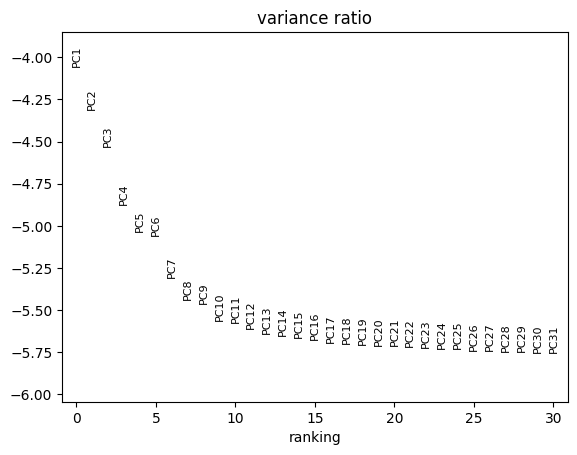

In [23]:
# Contribution of single PCs to the total variance in the data
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`
sc.pl.pca_variance_ratio(adata_nuclei, log=True)

In [24]:
adata_nuclei

AnnData object with n_obs × n_vars = 18799 × 477
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts'
    var: 'mean', 'std'
    uns: 'sopa_attrs', 'spatialdata_attrs', 'log1p', 'pca'
    obsm: 'spatial', 'tangram_pred', 'X_pca'
    varm: 'PCs'

In [25]:
# Group the PCs into a single AnnData object
X_nuc_pca = adata_nuclei.obsm["X_pca"][:, :13]

# As in MFA, divide the PCs by the square root of the maximal eigenvalue for each dataset separately
X_nuc_pca /= np.sqrt(np.max(adata_nuclei.uns["pca"]["variance"]))

# Save obs
nuclei_obs_all = adata_nuclei.obs.copy()

In [26]:
# Check var of first PC for each table is 1
print(np.var(adata_nuclei.obsm["X_pca"][:, 0]))

0.99994683


In [27]:
# Have a look to all the PCs var in the combined data
print("Nuc:")
for i in range(13):
    print(f"PC {i} variance: {np.var(adata_nuclei.obsm['X_pca'][:, i])}")

Nuc:
PC 0 variance: 0.9999468326568604
PC 1 variance: 0.7704108357429504
PC 2 variance: 0.620732843875885
PC 3 variance: 0.4386589527130127
PC 4 variance: 0.3755013942718506
PC 5 variance: 0.3655584752559662
PC 6 variance: 0.2857189476490021
PC 7 variance: 0.2496548593044281
PC 8 variance: 0.24418768286705017
PC 9 variance: 0.22130675613880157
PC 10 variance: 0.21817374229431152
PC 11 variance: 0.2104937583208084
PC 12 variance: 0.20456790924072266


In [28]:
# Clean memory
del adata_nuclei
gc.collect()

5573

##### Cyto :

In [29]:
adata_cyto = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cyto_{slide_id}.h5ad")

In [30]:
# Preprocess the data
sc.pp.normalize_total(adata_cyto, target_sum=1e4)
sc.pp.log1p(adata_cyto)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [31]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_cyto, max_value=10)

In [32]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_cyto, svd_solver="arpack", use_highly_variable=False)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


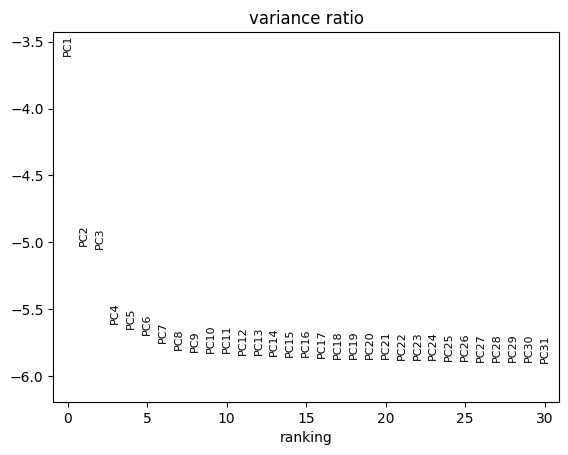

In [33]:
# Contribution of single PCs to the total variance in the data
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`
sc.pl.pca_variance_ratio(adata_cyto, log=True)

In [34]:
adata_cyto

AnnData object with n_obs × n_vars = 18799 × 477
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [35]:
# Group the PCs into a single AnnData object
X_cyto_pca = adata_cyto.obsm["X_pca"][:, :8]

# As in MFA, divide the PCs by the square root of the maximal eigenvalue for each dataset separately
X_cyto_pca /= np.sqrt(np.max(adata_cyto.uns["pca"]["variance"]))

# Check that obs_names align
assert np.array_equal(nuclei_obs_all['cell_id'].values, adata_cyto.obs['cell_id'].values), "Cell IDs do not match"

# Concatenate along columns (features) and keep only informative PCs
X_combined = np.concatenate([X_nuc_pca, X_cyto_pca], axis=1)

# Create a new AnnData to store these fused PCs
adata_combined = ad.AnnData(X=X_combined, obs=nuclei_obs_all.copy())

# Name the columns
adata_combined.var_names = [f"PC_nuc_{i}" for i in range(len(X_nuc_pca[0]))] + [f"PC_cyto_{i}" for i in range(len(X_cyto_pca[0]))]

In [36]:
# Check var of first PC for each table is 1
print(np.var(adata_cyto.obsm["X_pca"][:, 0]))

0.9999467


In [37]:
# Have a look to all the PCs var in the combined data
print("Cyto:")
for i in range(8):
    print(f"PC {i} variance: {np.var(adata_cyto.obsm['X_pca'][:, i])}")

Cyto:
PC 0 variance: 0.9999467134475708
PC 1 variance: 0.241397425532341
PC 2 variance: 0.23707622289657593
PC 3 variance: 0.13533897697925568
PC 4 variance: 0.1299416571855545
PC 5 variance: 0.1243581622838974
PC 6 variance: 0.11755570769309998
PC 7 variance: 0.11139719933271408


In [38]:
# Clean memory
del adata_cyto
gc.collect()

5219

In [39]:
# Add final labels coming from table nuclei and table cells

adata_combined.obs['transcript_cat'] = adata_combined.obs['cell_id'].map(cellid2transcript_cat).fillna('Unknown')

adata_combined.obs['final_label_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')
adata_combined.obs['final_label_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')

adata_combined.obs['label1_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel1).fillna('Unknown')
adata_combined.obs['label1_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel1).fillna('Unknown')

adata_combined.obs

region   slide     cell_id       area  \
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  13.523513   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1  14.247191   
aaaaaaam-1  nucleus_boundaries  morpho  aaaaaaam-1  20.884441   
aaaaaaao-1  nucleus_boundaries  morpho  aaaaaaao-1  12.599271   
aaaaaaba-1  nucleus_boundaries  morpho  aaaaaaba-1  30.344586   
...                        ...     ...         ...        ...   
aaaaiead-1  nucleus_boundaries  morpho  aaaaiead-1   6.366886   
aaaaieae-1  nucleus_boundaries  morpho  aaaaieae-1  27.319998   
aaaaieag-1  nucleus_boundaries  morpho  aaaaieag-1   6.321927   
aaaaieah-1  nucleus_boundaries  morpho  aaaaieah-1  30.885101   
aaaaieai-1  nucleus_boundaries  morpho  aaaaieai-1   7.631603   

                                  ct_tangram  transcript_counts  \
aaaaaaab-1    S100A+ preNeutrophil (cycling)                 10   
aaaaaaad-1        Effector/Memory CD4 T cell                 11   
aaaaaaam-1                  GZMB+ CD8 T cell                  6   
aaaaaaao-1                Gamma-delta T cell                  1   
aaaaaaba-1    S100A+ preNeutrophil (cycling)                 19   
...                                      ...                ...   
aaaaiead-1  Intermediate EPCAM+ erythroblast                  2   
aaaaieae-1                     Megakaryocyte                  6   
aaaaieag-1                              Treg                  1   
aaaaieah-1                              cDC1                  1   
aaaaieai-1                               pDC                  1   

            transcript_cat final_label_nuclei final_label_cells label1_nuclei  \
aaaaaaab-1               2             Less10       Specialized        less10   
aaaaaaad-1               3        Specialized       Specialized    Osteoblast   
aaaaaaam-1               2             Less10       Specialized        less10   
aaaaaaao-1               2             Less10       Specialized        less10   
aaaaaaba-1               3        Specialized       Specialized    Osteoblast   
...                    ...                ...               ...           ...   
aaaaiead-1               2             Less10           Unknown        less10   
aaaaieae-1               3             Less10           Unknown        less10   
aaaaieag-1               3             Less10           Unknown        less10   
aaaaieah-1               2             Less10       Specialized        less10   
aaaaieai-1               2             Less10          B_Plasma        less10   

                          label1_cells  
aaaaaaab-1                  Osteoblast  
aaaaaaad-1                  Osteoblast  
aaaaaaam-1                  Osteoblast  
aaaaaaao-1                  Osteoblast  
aaaaaaba-1                  Osteoblast  
...                                ...  
aaaaiead-1          Osteoblast/Unknown  
aaaaieae-1  Osteoblast/Unknown/Myeloid  
aaaaieag-1  Osteoblast/Unknown/Myeloid  
aaaaieah-1                  Osteoblast  
aaaaieai-1                           B  

[18799 rows x 11 columns]

In [40]:
adata_combined

AnnData object with n_obs × n_vars = 18799 × 21
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'

In [41]:
adata_combined.var

Empty DataFrame
Columns: []
Index: [PC_nuc_0, PC_nuc_1, PC_nuc_2, PC_nuc_3, PC_nuc_4, PC_nuc_5, PC_nuc_6, PC_nuc_7, PC_nuc_8, PC_nuc_9, PC_nuc_10, PC_nuc_11, PC_nuc_12, PC_cyto_0, PC_cyto_1, PC_cyto_2, PC_cyto_3, PC_cyto_4, PC_cyto_5, PC_cyto_6, PC_cyto_7]

## 4. PCA on the two separated PCA (late fusion) + Clustering

In [42]:
# Run a "second PCA" on the scaled features
# No scaling because we already scaled using the maximum eigenvalue for each table
sc.tl.pca(adata_combined)

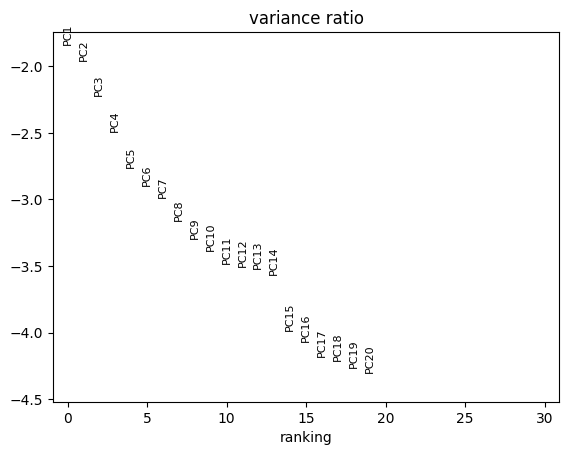

In [43]:
sc.pl.pca_variance_ratio(adata_combined, log=True)

In [44]:
adata_combined

AnnData object with n_obs × n_vars = 18799 × 21
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [45]:
# Neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=20, use_rep="X_pca", key_added='pca_n10_pcs20')
# Embedding the neighborhood graph using UMAP
sc.tl.umap(adata_combined, neighbors_key='pca_n10_pcs20')
# Leiden clustering directly clusters the neighborhood graph of cells
sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs20_leiden_res0.4', neighbors_key='pca_n10_pcs20')
sc.tl.leiden(adata_combined, resolution=0.6, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs20_leiden_res0.6', neighbors_key='pca_n10_pcs20')
sc.tl.leiden(adata_combined, resolution=0.8, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs20_leiden_res0.8', neighbors_key='pca_n10_pcs20')

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_48702/3836526640.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs20_leiden_res0.4', neighbors_key='pca_n10_pcs20')


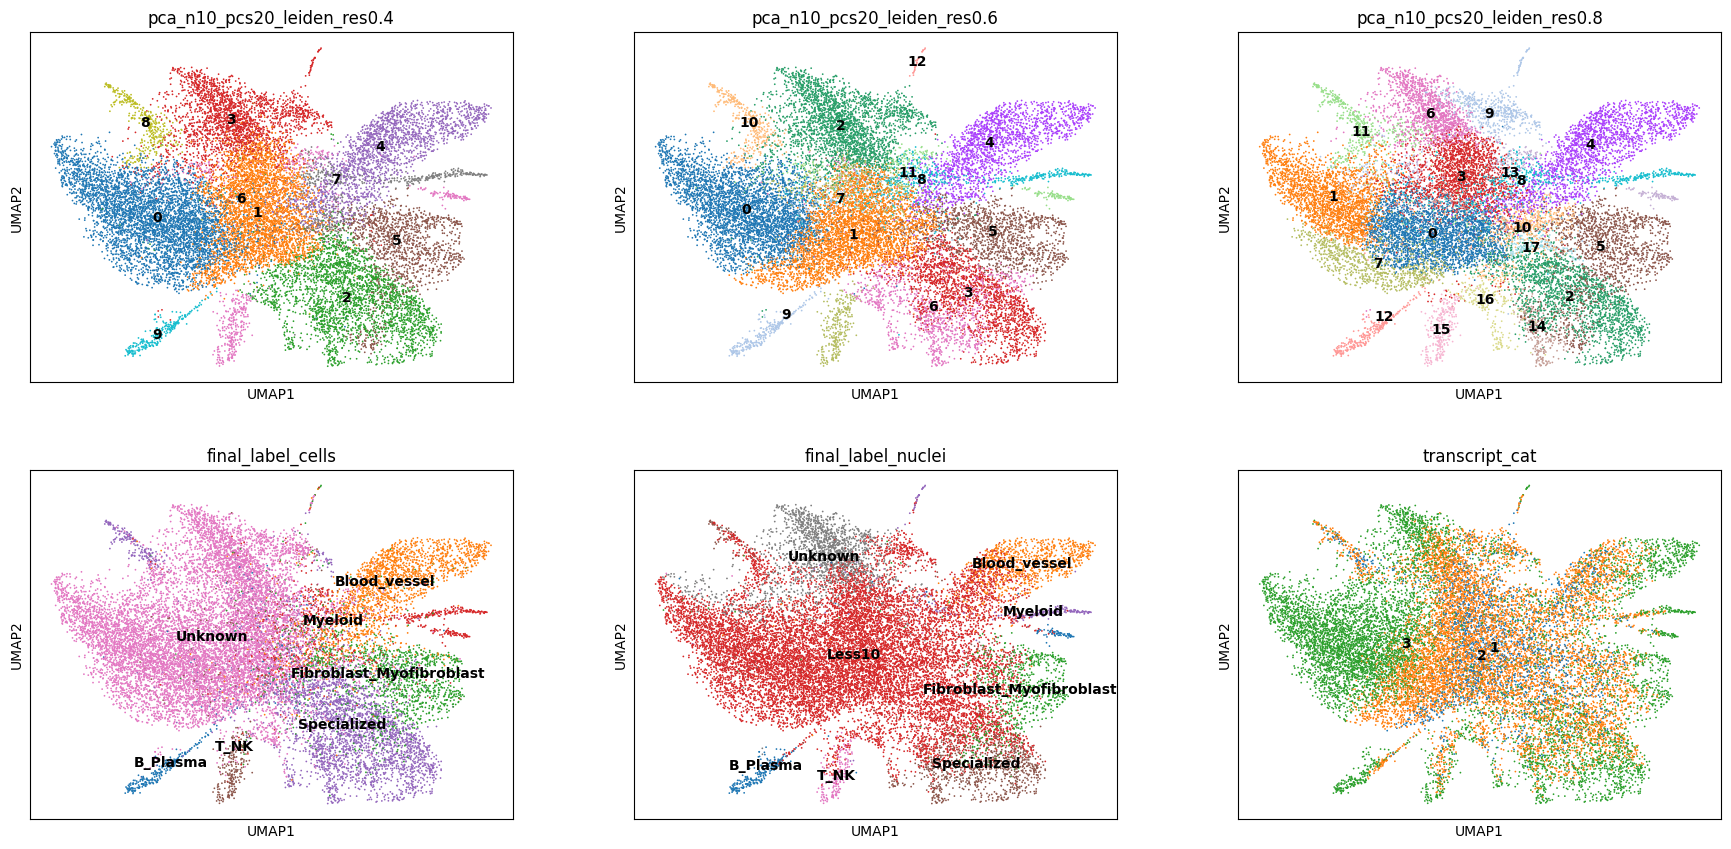

In [46]:
# Plot the clusters
adata_combined.obs['transcript_cat'] = pd.Categorical(adata_combined.obs['transcript_cat'])
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs20',
           color=['pca_n10_pcs20_leiden_res0.4', 'pca_n10_pcs20_leiden_res0.6', 'pca_n10_pcs20_leiden_res0.8', 'final_label_cells', 'final_label_nuclei', 'transcript_cat'],
           ncols=3, legend_loc='on data')

In [47]:
clustering_label = 'pca_n10_pcs20_leiden_res0.8'

In [48]:
adata_cells = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_cells_{slide_id}.h5ad")

In [49]:
# Put the clustering_label into the adata_cells to be able to use marker genes, and also final_label_cells and final_label_nuclei
cellid2clustering_label = dict(adata_combined.obs[['cell_id', clustering_label]].values)
adata_cells.obs["cluster_combined"] = adata_cells.obs['cell_id'].map(cellid2clustering_label).fillna('Unknown')
adata_cells.obs["final_label_cells"] = adata_cells.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')
adata_cells.obs["final_label_nuclei"] = adata_cells.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')


# Preprocess the adata_cells
sc.pp.normalize_total(adata_cells, target_sum=1e4)
sc.pp.log1p(adata_cells)

# Add X_umap to adata_cells, checking before cell_id alignment
assert np.array_equal(adata_cells.obs['cell_id'].values, adata_combined.obs['cell_id'].values), "Cell IDs do not match"
adata_cells.obsm['X_umap'] = adata_combined.obsm['X_umap']

# Wilcoxon rank-sum (Mann-Whitney-U) test. 
# You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.
sc.tl.rank_genes_groups(adata_cells, "cluster_combined", method="wilcoxon", corr_method="benjamini-hochberg", key_added="rank_genes_"+"cluster_combined")
# The top ranked genes per cluster
top_ranked_genes = pd.DataFrame(adata_cells.uns["rank_genes_"+"cluster_combined"]["names"]).iloc[:7, :]
list_genes = pd.concat([top_ranked_genes[col] for col in top_ranked_genes], ignore_index=True).tolist()

## 5. Analyze and get combined labels

### Helper functions

In [50]:
def analyze_clusters(adata, resolution_key):
    
    # Ensure the resolution key exists in obs
    if resolution_key not in adata.obs:
        raise ValueError(f"{resolution_key} not found in adata.obs.")
    
    # Group data by the specified clustering resolution
    cluster_groups = adata.obs.groupby(resolution_key)

    results = {}

    for cluster_id, group in cluster_groups:
        
        # Calculate dominant labels for final_label_cells
        label_cells_counts = group['final_label_cells'].value_counts(normalize=True)
        dominant_cells = label_cells_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for cells
        label1_cells_counts = group['label1_cells'].value_counts(normalize=True)
        top1_cells = label1_cells_counts.head(1) * 100

        # Calculate dominant labels for final_label_nuclei
        label_nuclei_counts = group['final_label_nuclei'].value_counts(normalize=True)
        dominant_nuclei = label_nuclei_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for nuclei
        label1_nuclei_counts = group['label1_nuclei'].value_counts(normalize=True)
        top1_nuclei = label1_nuclei_counts.head(1) * 100
        if top1_nuclei.keys()[0] == 'less_10_rna':
            top1_nuclei = label1_nuclei_counts.head(2).tail(1) * 100
        
        # Align categories for comparison
        common_categories = group['final_label_cells'].cat.categories.union(group['final_label_nuclei'].cat.categories)
        group['final_label_cells'] = group['final_label_cells'].cat.set_categories(common_categories)
        group['final_label_nuclei'] = group['final_label_nuclei'].cat.set_categories(common_categories)

        # Count different labels between final_label_cells and final_label_nuclei
        total_cells = len(group)  # Total number of cells in the cluster
        differing_labels_count_woUnknown = ((group['final_label_cells'] != group['final_label_nuclei']) & (group['final_label_nuclei'] != 'Unknown')  & (group['final_label_nuclei'] != 'Less10')).sum() / total_cells * 100
        differing_labels_count = (group['final_label_cells'] != group['final_label_nuclei']).sum() / total_cells * 100

        # Store the results
        results[cluster_id] = (dominant_cells.to_dict(), dominant_nuclei.to_dict(), top1_cells.to_dict(), top1_nuclei.to_dict(), differing_labels_count_woUnknown, differing_labels_count)

    return results

In [51]:
def analyze_cluster_dominance(cluster_analysis_results):
    
    clusters_unknown_cells = []
    clusters_different_top1 = []
    clusters_high_diff = []

    for cluster_id, (dominant_cells, dominant_nuclei, label1_cells, label1_nuclei, diff_percentage_woUnknown, _) in cluster_analysis_results.items():
        
        # Check if top 1 dominant_cells is 'Unknown' or 'Less10'
        
        top1_dominant_cells = max(dominant_cells, key=dominant_cells.get)
        if top1_dominant_cells == 'Unknown' or top1_dominant_cells == 'Less10':
            clusters_unknown_cells.append(cluster_id)
        
        # Check if top 1 for dominant_cells is different from dominant_nuclei
        
        top1_dominant_nuclei = max(dominant_nuclei, key=dominant_nuclei.get)

        if top1_dominant_nuclei == 'Unknown' or top1_dominant_nuclei == 'Less10':
            sorted_nuclei = sorted(dominant_nuclei.items(), key=lambda x: x[1], reverse=True)
            if len(sorted_nuclei) > 1:  # Make sure there's a second element
                top1_dominant_nuclei = sorted_nuclei[1][0]

        if top1_dominant_cells != top1_dominant_nuclei:
            clusters_different_top1.append(cluster_id)
        
        # Check if diff_percentage_woUnknown is greater than 40%
        
        if diff_percentage_woUnknown > 40:
            clusters_high_diff.append(cluster_id)

    print(f"Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': {clusters_unknown_cells}")
    print(f"Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): {clusters_different_top1}")
    print(f"Clusters where diff_percentage_woUnknown is greater than 40%: {clusters_high_diff}")

    print("=" * 50)

    clusters_to_analyse = set(clusters_unknown_cells + clusters_different_top1 + clusters_high_diff)
    for cluster_id in clusters_to_analyse:
        print(f"\nCluster ID: {cluster_id}")
        print(f"Dominant final_label_cells: {cluster_analysis_results[cluster_id][0]} - with dominant label1: {cluster_analysis_results[cluster_id][2]}")
        print(f"Dominant final_label_nuclei: {cluster_analysis_results[cluster_id][1]} - with dominant label1: {cluster_analysis_results[cluster_id][3]}")
        print(f"Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: {round(cluster_analysis_results[cluster_id][4], 2)} %")
        print(f"Count of differing labels: {round(cluster_analysis_results[cluster_id][5], 2)} %")
        print(f"% of cells in cluster: {round(len(adata_combined.obs[adata_combined.obs[clustering_label] == cluster_id]) / len(adata_combined.obs) * 100, 2)} %")
        print("-----")

In [52]:
def assign_final_labels(cluster_analysis_results, input_dict):
    
    dict_combined_labels = {}

    for cluster_id, (dominant_cells, _, _, _, _, _) in cluster_analysis_results.items():
        
        if cluster_id in input_dict:
            # Use the label from input_dict if cluster_id is in it
            dict_combined_labels[cluster_id] = input_dict[cluster_id]
        else:
            # Otherwise, use the dominant label from final_label_cells
            dict_combined_labels[cluster_id] = max(dominant_cells, key=dominant_cells.get)

    return dict_combined_labels

### Analysis

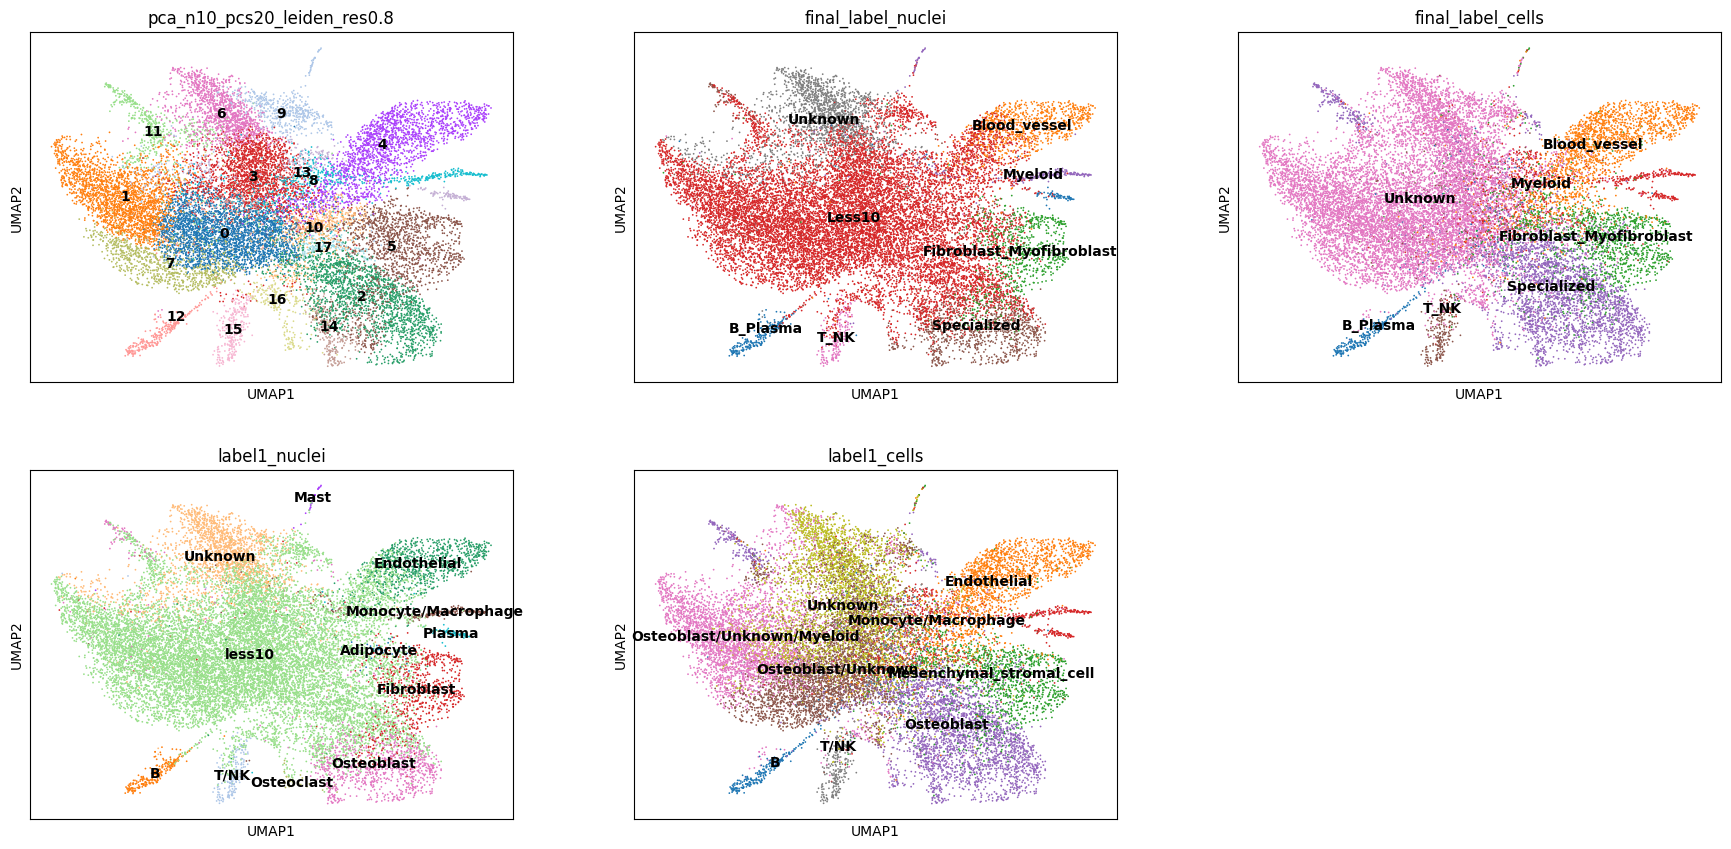

In [53]:
# Plot the clusters
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs20',
           color=[clustering_label, 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'],
           ncols=3, legend_loc='on data')

In [54]:
cluster_analysis_results = analyze_clusters(adata_combined, clustering_label)

for cluster_id, (dominant_cells, dominant_nuclei, _, _, diff_count_woUnknown, diff_count) in cluster_analysis_results.items():
    print("=" * 50)
    print(f"Cluster ID: {cluster_id}")
    print(f"Dominant final_label_cells: {dominant_cells}")
    print(f"Dominant final_label_nuclei: {dominant_nuclei}")
    print(f"Count of differing labels without 'Unknown/Less10' label for Nuclei: {round(diff_count_woUnknown, 2)} %")
    print(f"Count of differing labels: {round(diff_count, 2)} %\n")

Cluster ID: 0
Dominant final_label_cells: {'Unknown': 85.71428571428571, 'Specialized': 6.101938262742283}
Dominant final_label_nuclei: {'Less10': 99.78463747307968, 'Unknown': 0.14357501794687724}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 0.07 %
Count of differing labels: 99.86 %

Cluster ID: 1
Dominant final_label_cells: {'Unknown': 99.42957437472576, 'T_NK': 0.26327336551118913}
Dominant final_label_nuclei: {'Less10': 88.72312417727073, 'Unknown': 8.951294427380429}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 2.28 %
Count of differing labels: 91.0 %

Cluster ID: 2
Dominant final_label_cells: {'Specialized': 89.3188854489164, 'Unknown': 7.1723426212590295}
Dominant final_label_nuclei: {'Less10': 65.53147574819401, 'Specialized': 31.940144478844168}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 3.1 %
Count of differing labels: 68.63 %

Cluster ID: 3
Dominant final_label_cells: {'Unknown': 83.09932397295891, 'Sp

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_48702/1125182952.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_groups = adata.obs.groupby(resolution_key)


In [55]:
analyze_cluster_dominance(cluster_analysis_results)

Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': ['0', '1', '3', '6', '7', '9', '11', '13', '16']
Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): ['6', '10', '11', '13', '16', '17']
Clusters where diff_percentage_woUnknown is greater than 40%: []

Cluster ID: 11
Dominant final_label_cells: {'Unknown': 61.8348623853211, 'Specialized': 34.4954128440367} - with dominant label1: {'Osteoblast': 34.4954128440367}
Dominant final_label_nuclei: {'Less10': 78.1651376146789, 'Specialized': 11.926605504587156} - with dominant label1: {'less10': 78.1651376146789}
Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: 2.2 %
Count of differing labels: 81.47 %
% of cells in cluster: 2.9 %
-----

Cluster ID: 7
Dominant final_label_cells: {'Unknown': 97.33629300776914, 'Specialized': 1.3318534961154271} - with dominant label1: {'Osteoblast/Unknown': 67.59156492785795}
Dominant final_label_nuclei: {'Less1

In [56]:
dict_combined_labels = assign_final_labels(cluster_analysis_results, {'10': 'Unknown', '17': 'Unknown'})
dict_combined_labels

{'0': 'Unknown',
 '1': 'Unknown',
 '2': 'Specialized',
 '3': 'Unknown',
 '4': 'Blood_vessel',
 '5': 'Fibroblast_Myofibroblast',
 '6': 'Unknown',
 '7': 'Unknown',
 '8': 'Myeloid',
 '9': 'Unknown',
 '10': 'Unknown',
 '11': 'Unknown',
 '12': 'B_Plasma',
 '13': 'Unknown',
 '14': 'Specialized',
 '15': 'T_NK',
 '16': 'Unknown',
 '17': 'Unknown'}

In [57]:
adata_combined.obs['final_label_combined'] = adata_combined.obs[clustering_label].map(dict_combined_labels)
adata_combined.obs

region   slide     cell_id       area  \
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  13.523513   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1  14.247191   
aaaaaaam-1  nucleus_boundaries  morpho  aaaaaaam-1  20.884441   
aaaaaaao-1  nucleus_boundaries  morpho  aaaaaaao-1  12.599271   
aaaaaaba-1  nucleus_boundaries  morpho  aaaaaaba-1  30.344586   
...                        ...     ...         ...        ...   
aaaaiead-1  nucleus_boundaries  morpho  aaaaiead-1   6.366886   
aaaaieae-1  nucleus_boundaries  morpho  aaaaieae-1  27.319998   
aaaaieag-1  nucleus_boundaries  morpho  aaaaieag-1   6.321927   
aaaaieah-1  nucleus_boundaries  morpho  aaaaieah-1  30.885101   
aaaaieai-1  nucleus_boundaries  morpho  aaaaieai-1   7.631603   

                                  ct_tangram  transcript_counts  \
aaaaaaab-1    S100A+ preNeutrophil (cycling)                 10   
aaaaaaad-1        Effector/Memory CD4 T cell                 11   
aaaaaaam-1                  GZMB+ CD8 T cell                  6   
aaaaaaao-1                Gamma-delta T cell                  1   
aaaaaaba-1    S100A+ preNeutrophil (cycling)                 19   
...                                      ...                ...   
aaaaiead-1  Intermediate EPCAM+ erythroblast                  2   
aaaaieae-1                     Megakaryocyte                  6   
aaaaieag-1                              Treg                  1   
aaaaieah-1                              cDC1                  1   
aaaaieai-1                               pDC                  1   

           transcript_cat final_label_nuclei final_label_cells label1_nuclei  \
aaaaaaab-1              2             Less10       Specialized        less10   
aaaaaaad-1              3        Specialized       Specialized    Osteoblast   
aaaaaaam-1              2             Less10       Specialized        less10   
aaaaaaao-1              2             Less10       Specialized        less10   
aaaaaaba-1              3        Specialized       Specialized    Osteoblast   
...                   ...                ...               ...           ...   
aaaaiead-1              2             Less10           Unknown        less10   
aaaaieae-1              3             Less10           Unknown        less10   
aaaaieag-1              3             Less10           Unknown        less10   
aaaaieah-1              2             Less10       Specialized        less10   
aaaaieai-1              2             Less10          B_Plasma        less10   

                          label1_cells pca_n10_pcs20_leiden_res0.4  \
aaaaaaab-1                  Osteoblast                           8   
aaaaaaad-1                  Osteoblast                           2   
aaaaaaam-1                  Osteoblast                           8   
aaaaaaao-1                  Osteoblast                           2   
aaaaaaba-1                  Osteoblast                           2   
...                                ...                         ...   
aaaaiead-1          Osteoblast/Unknown                           1   
aaaaieae-1  Osteoblast/Unknown/Myeloid                           0   
aaaaieag-1  Osteoblast/Unknown/Myeloid                           0   
aaaaieah-1                  Osteoblast                           1   
aaaaieai-1                           B                           1   

           pca_n10_pcs20_leiden_res0.6 pca_n10_pcs20_leiden_res0.8  \
aaaaaaab-1                          10                          11   
aaaaaaad-1                           6                           2   
aaaaaaam-1                          10                          11   
aaaaaaao-1                           3                           2   
aaaaaaba-1                           3                           2   
...                                ...                         ...   
aaaaiead-1                           7                           3   
aaaaieae-1                           0                           1   
aaaaie

In [58]:
adata_combined.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Unknown                     11772
Specialized                  2235
Blood_vessel                 1910
Fibroblast_Myofibroblast     1466
Myeloid                       708
B_Plasma                      440
T_NK                          268
Name: count, dtype: int64

In [59]:
# Create final table, adding cell_id with less than 10 transcripts

adata_nuclei_ini = sc.read_h5ad(f"/Users/felicie-giraud-sauveur/Documents/HE2CellType/adata_TEMP/adata_nuclei_ini_{slide_id}.h5ad")

adata_combined_missing = adata_nuclei_ini[~adata_nuclei_ini.obs_names.isin(adata_combined.obs_names)].copy()
adata_combined_missing.obs['final_label_combined'] = 'Less10'
adata_combined_missing.obs['final_label_nuclei'] = 'Less10'
adata_combined_missing.obs['final_label_cells'] = 'Less10'
print(adata_combined.shape[0] + adata_combined_missing.shape[0])

adata_combined_all = ad.concat([adata_combined, adata_combined_missing], join="outer", merge="first", uns_merge="first", pairwise=True)
print(adata_combined_all.shape[0])

33801
33801


In [60]:
# Clean memory
del adata_combined_missing, adata_nuclei_ini
gc.collect()

57587

In [61]:
adata_combined_all

AnnData object with n_obs × n_vars = 33801 × 562
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells', 'pca_n10_pcs20_leiden_res0.4', 'pca_n10_pcs20_leiden_res0.6', 'pca_n10_pcs20_leiden_res0.8', 'final_label_combined'
    uns: 'pca', 'pca_n10_pcs20', 'umap', 'pca_n10_pcs20_leiden_res0.4', 'pca_n10_pcs20_leiden_res0.6', 'pca_n10_pcs20_leiden_res0.8', 'pca_n10_pcs20_leiden_res0.4_colors', 'pca_n10_pcs20_leiden_res0.6_colors', 'pca_n10_pcs20_leiden_res0.8_colors', 'final_label_cells_colors', 'final_label_nuclei_colors', 'transcript_cat_colors', 'label1_nuclei_colors', 'label1_cells_colors', 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    obsp: 'pca_n10_pcs20_distances', 'pca_n10_pcs20_connectivities'

In [62]:
adata_combined_all.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Less10                      15002
Unknown                     11772
Specialized                  2235
Blood_vessel                 1910
Fibroblast_Myofibroblast     1466
Myeloid                       708
B_Plasma                      440
T_NK                          268
Name: count, dtype: int64

In [63]:
sdata_final = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('shapes',))

In [64]:
# Add in sdata final
sdata_final.tables['table_combined'] = adata_combined_all

In [65]:
adata_combined_all

AnnData object with n_obs × n_vars = 33801 × 562
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells', 'pca_n10_pcs20_leiden_res0.4', 'pca_n10_pcs20_leiden_res0.6', 'pca_n10_pcs20_leiden_res0.8', 'final_label_combined'
    uns: 'pca', 'pca_n10_pcs20', 'umap', 'pca_n10_pcs20_leiden_res0.4', 'pca_n10_pcs20_leiden_res0.6', 'pca_n10_pcs20_leiden_res0.8', 'pca_n10_pcs20_leiden_res0.4_colors', 'pca_n10_pcs20_leiden_res0.6_colors', 'pca_n10_pcs20_leiden_res0.8_colors', 'final_label_cells_colors', 'final_label_nuclei_colors', 'transcript_cat_colors', 'label1_nuclei_colors', 'label1_cells_colors', 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    obsp: 'pca_n10_pcs20_distances', 'pca_n10_pcs20_connectivities'

In [66]:
# Convert in str the final_label_combined, final_label_cells and final_label_nuclei to see it in Napari
sdata_final.tables['table_combined'].obs['final_label_combined'] = sdata_final.tables['table_combined'].obs['final_label_combined'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_cells'] = sdata_final.tables['table_combined'].obs['final_label_cells'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_nuclei'] = sdata_final.tables['table_combined'].obs['final_label_nuclei'].astype(str)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


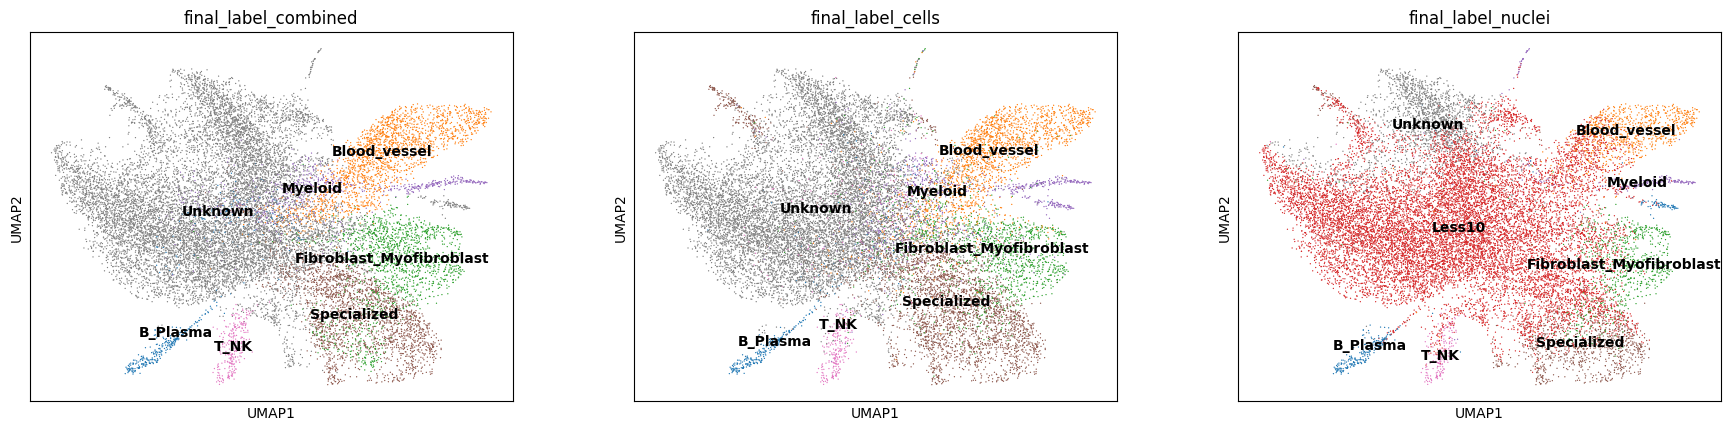

In [67]:
sc.pl.umap(sdata_final.tables['table_combined'], color=['final_label_combined', 'final_label_cells', 'final_label_nuclei'], ncols=3, legend_loc='on data')

In [68]:
# Put table_combined as annotating cell_boundaries

sdata_final["table_combined"].obs["region"] = "cell_boundaries"
sdata_final.tables["table_combined"].obs['region'] = sdata_final.tables["table_combined"].obs['region'].astype('category')
sdata_final.set_table_annotates_spatialelement(table_name="table_combined", region="cell_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata_final["table_combined"])
print(region, region_key, instance_key)

cell_boundaries region cell_id


In [69]:
# Color for final label in Napari

to_hex = partial(colors.to_hex, keep_alpha=True)

# Normalize the RGB values to the range [0, 1] by dividing by 255
napari_color = {
                "T_NK": to_hex(to_rgba([255/255, 15/255, 15/255])[:3]),                      # Red
                "B_Plasma": to_hex(to_rgba([255/255, 143/255, 15/255])[:3]),                 # Orange
                "Myeloid": to_hex(to_rgba([255/255, 211/255, 15/255])[:3]),                  # Yellow
                "Blood_vessel": to_hex(to_rgba([70/255, 128/255, 0/255])[:3]),               # Dark Green
                "Fibroblast_Myofibroblast": to_hex(to_rgba([156/255, 255/255, 36/255])[:3]), # Light Green
                "Epithelial": to_hex(to_rgba([57/255, 208/255, 133/255])[:3]),               # Blue Green
                "Specialized": to_hex(to_rgba([69/255, 237/255, 255/255])[:3]),              # Turquoise
                "Melanocyte": to_hex(to_rgba([22/255, 169/255, 223/255])[:3]),               # Blue
                "Stem_like": to_hex(to_rgba([22/255, 69/255, 223/255])[:3]),                 # Dark Blue
                "Glioblastoma": to_hex(to_rgba([130/255, 55/255, 235/255])[:3]),             # Purple
                "Unknown": to_hex(to_rgba([0/255, 0/255, 0/255])[:3]),                       # Black
                "Less10": to_hex(to_rgba([143/255, 143/255, 143/255])[:3])                   # Grey
                }

sdata_final.tables['table_combined'].uns["final_label_combined_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_cells_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_nuclei_colors"] = napari_color

In [70]:
sdata_final.write_element("table_combined")